# Data Extraction from Images

In [ ]:
from glob import glob
import wfdb
import numpy as np
from tqdm import tqdm
import biosppy
import matplotlib.pyplot as plt
import cv2
import os
import math

def get_records():

    paths = glob('db/*.atr')
    paths = [path[:-4] for path in paths]
    paths.sort()
    return paths

def segmentation(records, type, output_dir=''):
    os.makedirs(output_dir, exist_ok=True)
    results = []
    kernel = np.ones((4, 4), np.uint8)
    count = 1
    mean_v = -0.33859
    std_v = 0.472368
    floor = mean_v - 3*std_v
    ceil = mean_v + 3*std_v
    for e in tqdm(records):
        signals, fields = wfdb.rdsamp(e, channels = [0])
        ann = wfdb.rdann(e, 'atr')
        good = [type]
        ids = np.in1d(ann.symbol, good)
        imp_beats = ann.sample[ids]
        beats = (ann.sample)
        for i in tqdm(imp_beats):
            beats = list(beats)
            j = beats.index(i)
            if(j!=0 and j!=(len(beats)-1)):
                data = (signals[beats[j]-96: beats[j]+96, 0])
                results.append(data)
                plt.axis([0, 192, floor, ceil])
                plt.plot(data, linewidth=0.5)
                plt.xticks([]), plt.yticks([])
                for spine in plt.gca().spines.values():
                    spine.set_visible(False)
                filename = output_dir + 'fig_{}'.format(count) + '.png'
                plt.savefig(filename)
                plt.close()
                im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                im_gray = cv2.erode(im_gray, kernel, iterations=1)
                im_gray = cv2.resize(im_gray, (192, 128), interpolation=cv2.INTER_LANCZOS4)
                cv2.imwrite(filename, im_gray)
                print('img writtten {}'.format(filename))
                count += 1
    return results



if __name__ == "__main__":
    records = get_records()
    labels = ['N', 'L', 'R', 'A', 'V', '/', 'E', '!']
    output_dirs = ['NOR/', 'LBBB/', 'RBBB/', 'APC/', 'PVC/', 'PAB/', 'VEB/', 'VFE/']
    for type, output_dir in zip(labels, output_dirs):
        sgs = segmentation(records, type, output_dir='./MIT-BIH_AD/'+output_dir)

# Data Extraction

In [54]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

test = pd.read_csv('mitbih_test.csv',header=None)
train = pd.read_csv('mitbih_train.csv',header=None)

Description about Training Data

In [2]:
print(train.shape)
print(train.info())
print(train.head())

(87554, 188)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9   ...   178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011 ...   0.0  0.0  0.0  0.0  0.

Class Distribution in Train Set

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


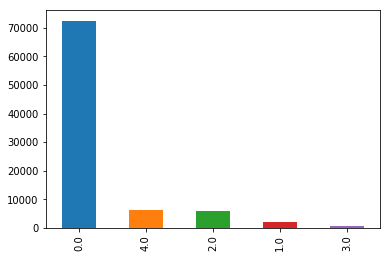

In [39]:
CountStatus = pd.value_counts(train[187], sort=True)
print(CountStatus)
CountStatus.plot.bar()

Description about Testing Data

In [44]:
print(test.shape)
print(test.info())
print(test.head())

(21892, 188)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
None
        0         1         2         3         4         5         6    \
0  1.000000  0.758264  0.111570  0.000000  0.080579  0.078512  0.066116   
1  0.908425  0.783883  0.531136  0.362637  0.366300  0.344322  0.333333   
2  0.730088  0.212389  0.000000  0.119469  0.101770  0.101770  0.110619   
3  1.000000  0.910417  0.681250  0.472917  0.229167  0.068750  0.000000   
4  0.570470  0.399329  0.238255  0.147651  0.000000  0.003356  0.040268   

        7         8         9   ...   178  179  180  181  182  183  184  185  \
0  0.049587  0.047521  0.035124 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.307692  0.296703  0.300366 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.123894  0.115044  0.132743 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.004167  0.014583  0.054167 ...   0.0  0.0  0.0  0.0  0.0

Class Distribution in Test Set

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


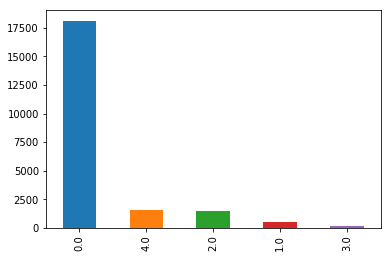

In [43]:
CountStatus = pd.value_counts(test[187], sort=True)
print(CountStatus)

CountStatus.plot.bar()

# Trying out Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Ytrain = train[187]
Xtrain = train.drop(187,axis=1)

Ytest = test[187]
Xtest = test.drop(187,axis=1)

In [46]:
rfc1 = RandomForestClassifier()
rfc1.fit(Xtrain, Ytrain)

Ypred = rfc1.predict(Xtest)
yhat_pp = rfc1.predict_proba(Xtest)
print(classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     18118
         1.0       0.97      0.60      0.74       556
         2.0       0.98      0.88      0.93      1448
         3.0       0.85      0.59      0.70       162
         4.0       0.99      0.94      0.97      1608

   micro avg       0.97      0.97      0.97     21892
   macro avg       0.95      0.80      0.86     21892
weighted avg       0.97      0.97      0.97     21892



# Data imputation using SMOTE

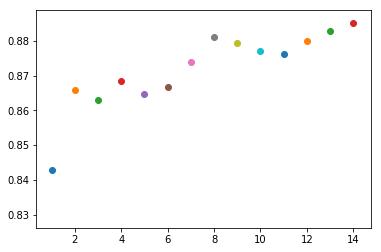

In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import *

rfc = RandomForestClassifier(random_state=620)

for k in range(1,15):
    sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=240)
    X_smote, y_smote = sm.fit_sample(Xtrain, Ytrain)
    rfc.fit(X_smote,y_smote)
    smote_predict = rfc.predict(Xtest)
    recall = recall_score(Ytest, smote_predict, average='macro')
    plt.scatter(k, recall)

In [52]:
CountStatus = pd.value_counts(y_smote, sort=True)
print(CountStatus)

1.0    72471
3.0    72471
4.0    72471
2.0    72471
0.0    72471
dtype: int64


In [55]:
sm = SMOTE(sampling_strategy='auto',k_neighbors=11, random_state=240)
X_smote, y_smote = sm.fit_sample(Xtrain, Ytrain)
print(X_smote.shape)

X_train,y_train,X_val,y_val = train_test_split(Xtrain,Ytrain,test_size=0.8)

rfc2 = RandomForestClassifier(random_state=620)
rfc2.fit(X_smote, y_smote)

y_predict2 = rfc2.predict(Xtest)

yhat_pp = rfc2.predict_proba(Xtest)

print(classification_report(Ytest, y_predict2))

(362355, 187)
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.80      0.77      0.79       556
         2.0       0.95      0.93      0.94      1448
         3.0       0.74      0.72      0.73       162
         4.0       0.98      0.97      0.97      1608

   micro avg       0.98      0.98      0.98     21892
   macro avg       0.89      0.88      0.88     21892
weighted avg       0.98      0.98      0.98     21892



# Convolution Neural Network

Data Separation

In [4]:
M = train.values
X = M[:, :-1]
y = M[:, -1]

C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

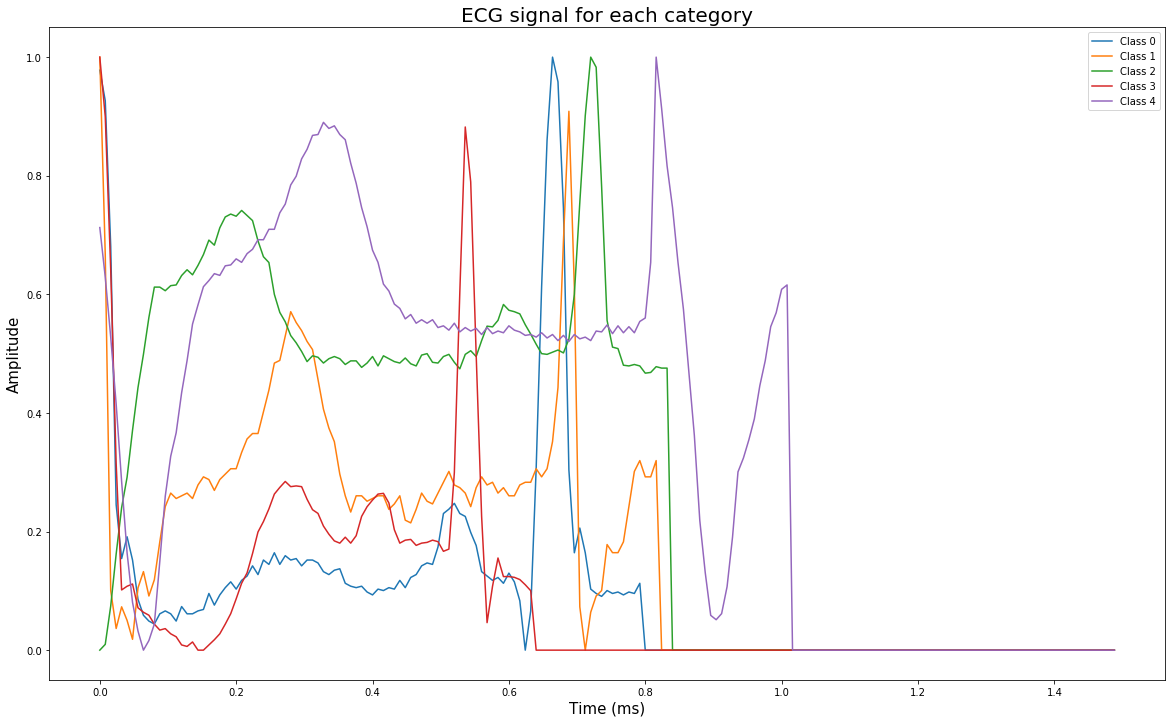

In [30]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Class 0")
plt.plot(x, X[C1, :][0], label="Class 1")
plt.plot(x, X[C2, :][0], label="Class 2")
plt.plot(x, X[C3, :][0], label="Class 3")
plt.plot(x, X[C4, :][0], label="Class 4")
plt.legend()
plt.title("ECG signal for each category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

Data Augmentation Technique

In [5]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

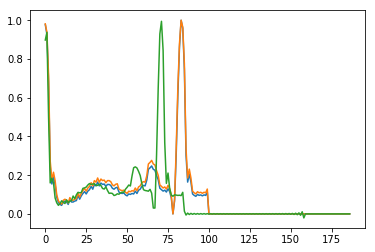

In [6]:
import random
from scipy.signal import resample
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

Train Data and Validation Data Separation

In [7]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)

classes = np.ones(shape=(result.shape[0],), dtype=int)*3

X = np.vstack([X, result])
y = np.hstack([y, classes])

subC0 = np.random.choice(C0, 400)
subC1 = np.random.choice(C1, 400)
subC2 = np.random.choice(C2, 400)
subC3 = np.random.choice(C3, 400)
subC4 = np.random.choice(C4, 400)

from sklearn.utils import shuffle

X_val = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_val = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

In [8]:
from sklearn.preprocessing import OneHotEncoder

X_train = np.expand_dims(X_train, 2)
X_val = np.expand_dims(X_val, 2)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)

X_train (88279, 187, 1)
y_train (88279, 5)
X_val (2000, 187, 1)
y_val (2000, 5)


In [9]:
n_obs, feature, depth = X_train.shape
batch_size = 500

# Model

In [20]:
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense, Activation, Input
from keras.optimizers import Adam

#Model implemented in the research paper

inp = Input(shape=(feature, depth))

C11 = Conv1D(filters=32, kernel_size=3, strides=1)(inp)
A11 = Activation("relu")(C11)
M11 = MaxPooling1D(pool_size=2, strides=2)(A11)


C21 = Conv1D(filters=32, kernel_size=4, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
M21 = MaxPooling1D(pool_size=2, strides=2)(A21)


C31 = Conv1D(filters=32, kernel_size=4, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
M31 = MaxPooling1D(pool_size=2, strides=2)(A31)

F1 = Flatten()(M31)
D1 = Dense(30)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(20)(A6)
A6 = Activation("relu")(D2)
D3 = Dense(5)(D2)
A7 = Activation("softmax")(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 185, 32)           128       
_________________________________________________________________
activation_21 (Activation)   (None, 185, 32)           0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 92, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 92, 32)            4128      
_________________________________________________________________
activation_22 (Activation)   (None, 92, 32)            0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 46, 32)            0         
__________

In [22]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 88279 samples, validate on 2000 samples
Epoch 1/10
88279/88279 [==============================] - 3461s 39ms/step - loss: 0.4619 - acc: 0.8672 - val_loss: 1.0492 - val_acc: 0.6440
Epoch 2/10
88279/88279 [==============================] - 3454s 39ms/step - loss: 0.2107 - acc: 0.9420 - val_loss: 0.7619 - val_acc: 0.7765
Epoch 3/10
88279/88279 [==============================] - 3471s 39ms/step - loss: 0.1587 - acc: 0.9554 - val_loss: 0.6605 - val_acc: 0.8115
Epoch 4/10
88279/88279 [==============================] - 3507s 40ms/step - loss: 0.1336 - acc: 0.9620 - val_loss: 0.5941 - val_acc: 0.8220
Epoch 5/10
88279/88279 [==============================] - 3449s 39ms/step - loss: 0.1185 - acc: 0.9663 - val_loss: 0.6169 - val_acc: 0.8070
Epoch 6/10
88279/88279 [==============================] - 3461s 39ms/step - loss: 0.1091 - acc: 0.9686 - val_loss: 0.5883 - val_acc: 0.8295
Epoch 7/10
88279/88279 [==============================] - 3501s 40ms/step - loss: 0.1025 - acc: 0.9708 - val_lo

Saving the weights

In [23]:
model.save_weights('heart_beat_weights.h5')

Evaluating the classifier for Validation Data

In [24]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val, batch_size=1000)
print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.62      0.99      0.77       400
           1       1.00      0.66      0.79       400
           2       0.92      0.94      0.93       400
           3       0.98      0.78      0.87       400
           4       1.00      0.92      0.96       400

   micro avg       0.86      0.86      0.86      2000
   macro avg       0.90      0.86      0.86      2000
weighted avg       0.90      0.86      0.86      2000



Test Data Separation

In [25]:
M = test.values
X_test = M[:, :-1]
y_test = M[:, -1]

In [ ]:
X_test = np.expand_dims(X_test, 2)
ohe = OneHotEncoder()
y_test = ohe.fit_transform(y_test.reshape(-1,1))
print("X_train", X_test.shape)
print("y_train", y_test.shape)

Prediction for Test Data

In [27]:
y_pred2 = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred2.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18118
           1       0.89      0.62      0.73       556
           2       0.94      0.91      0.93      1448
           3       0.65      0.78      0.71       162
           4       1.00      0.94      0.97      1608

   micro avg       0.97      0.97      0.97     21892
   macro avg       0.89      0.85      0.86     21892
weighted avg       0.97      0.97      0.97     21892



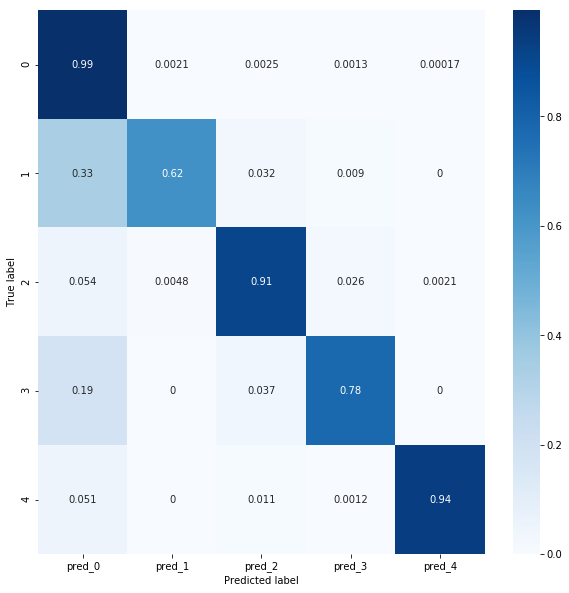

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat=pd.DataFrame(np.array(confusion_matrix(y_test.argmax(axis=1), y_pred2.argmax(axis=1))),index = ['0', '1','2', '3','4'],columns=['pred_0', 'pred_1','pred_2', 'pred_3','pred_4'])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()